# Compare Models Performance

In [149]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score

sns.set_theme(style="whitegrid", palette="colorblind")

## Load Experimental Data

In [170]:
# Define paths to the results files
result_paths = {
    "Claude 3.5 Haiku": Path("../results/results_self_play_claude-3.5-haiku.csv"),
    "Claude 3.5 Sonnet": Path("../results/results_sonnet_on_haikus_debate.csv"),
    "Claude 3.5 Sonnet USER_PROMPT2": Path("../results/results_sonnet_on_haikus_debate_USER_PROMPT2.csv"),
    "DeepSeek V3": Path("../results/results_deepseek_on_haikus_debate.csv"),
    "DeepSeek V3 USER_PROMPT2": Path("../results/results_deepseek_on_haikus_debate_USER_PROMPT2.csv"),
}

# Load data into DataFrames
dataframes = {model: pd.read_csv(path) for model, path in result_paths.items()}

# Display sample data
for model, df in dataframes.items():
    print(f"\n{model} Data Sample:")
    display(df.head())


Claude 3.5 Haiku Data Sample:


,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff,Baseline Correct,Judge Correct
0,524987bd2b554b2f909ba71339258d7b,9893e7f7-71d8-429e-9c50-12b30ce18200,LowConflict,1,proved,unknown,disproved,2,0.500000,10,0.833333,12,0.333333,0,0
1,524987bd2b554b2f909ba71339258d7b,6019d0e5-83ff-4bc3-a012-fb724ba15a4c,LowConflict,2,proved,unknown,disproved,1,1.000000,7,1.000000,7,0.000000,0,0
2,524987bd2b554b2f909ba71339258d7b,608c69ca-981c-43b8-b630-6e4903a0943b,LowConflict,-1,proved,unknown,disproved,1,0.857143,7,1.000000,7,-0.142857,0,0
3,0f72d2ac8542323babccd7fdb6584841,ec49fd55-3d79-4a5c-80e5-5c08f03a1785,LowConflict,1,proved,proved,proved,1,0.875000,8,1.000000,3,-0.125000,1,1
4,0f72d2ac8542323babccd7fdb6584841,bf0c225c-41bf-43bc-b8ba-10ce944c5675,LowConflict,2,proved,proved,proved,2,1.000000,5,1.000000,6,0.000000,1,1



Claude 3.5 Sonnet Data Sample:


,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff,Baseline Correct,Judge Correct
0,017b322cf0dd120cab08cf4060708b61,5d02dff9-493f-4215-87ca-aa978ecf14bb,HighConflict,1,proved,unknown,disproved,2,0.666667,3,1.000000,6,0.333333,0,0
1,017b322cf0dd120cab08cf4060708b61,b16ec15f-3239-4134-8c53-6cba963eebd0,HighConflict,-1,proved,unknown,unknown,2,1.000000,8,1.000000,7,0.000000,0,0
2,017b322cf0dd120cab08cf4060708b61,f90a85fb-3a0f-4e89-8e92-01f401ccae07,HighConflict,2,proved,unknown,proved,2,1.000000,3,1.000000,8,0.000000,0,1
3,01e8feaa80c08cd2188a9ab3e1b8be5e,3787fe8f-16ae-4db5-b242-3d76edb2063c,LowConflict,-1,disproved,disproved,unknown,1,0.428571,7,0.909091,11,-0.480519,1,0
4,01e8feaa80c08cd2188a9ab3e1b8be5e,56b43d93-9a18-4264-98d1-31b87b37196c,LowConflict,2,disproved,disproved,unknown,1,1.000000,6,1.000000,9,0.000000,1,0



Claude 3.5 Sonnet USER_PROMPT2 Data Sample:


,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff,Baseline Correct,Judge Correct
0,017b322cf0dd120cab08cf4060708b61,5d02dff9-493f-4215-87ca-aa978ecf14bb,HighConflict,1,proved,unknown,disproved,2,0.666667,3,1.000000,6,0.333333,0,0
1,017b322cf0dd120cab08cf4060708b61,b16ec15f-3239-4134-8c53-6cba963eebd0,HighConflict,-1,proved,unknown,unknown,2,1.000000,8,1.000000,7,0.000000,0,0
2,017b322cf0dd120cab08cf4060708b61,f90a85fb-3a0f-4e89-8e92-01f401ccae07,HighConflict,2,proved,unknown,proved,2,1.000000,3,1.000000,8,0.000000,0,1
3,01e8feaa80c08cd2188a9ab3e1b8be5e,3787fe8f-16ae-4db5-b242-3d76edb2063c,LowConflict,-1,disproved,disproved,unknown,1,0.428571,7,0.909091,11,-0.480519,1,0
4,01e8feaa80c08cd2188a9ab3e1b8be5e,56b43d93-9a18-4264-98d1-31b87b37196c,LowConflict,2,disproved,disproved,unknown,1,1.000000,6,1.000000,9,0.000000,1,0



DeepSeek V3 Data Sample:


,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff,Baseline Correct,Judge Correct
0,017b322cf0dd120cab08cf4060708b61,5d02dff9-493f-4215-87ca-aa978ecf14bb,HighConflict,1,proved,disproved,disproved,2,0.666667,3,1.000000,6,0.333333,0,0
1,017b322cf0dd120cab08cf4060708b61,b16ec15f-3239-4134-8c53-6cba963eebd0,HighConflict,-1,proved,disproved,unknown,2,1.000000,8,1.000000,7,0.000000,0,0
2,017b322cf0dd120cab08cf4060708b61,f90a85fb-3a0f-4e89-8e92-01f401ccae07,HighConflict,2,proved,disproved,proved,2,1.000000,3,1.000000,8,0.000000,0,1
3,01e8feaa80c08cd2188a9ab3e1b8be5e,3787fe8f-16ae-4db5-b242-3d76edb2063c,LowConflict,-1,disproved,proved,unknown,1,0.428571,7,0.909091,11,-0.480519,0,0
4,01e8feaa80c08cd2188a9ab3e1b8be5e,56b43d93-9a18-4264-98d1-31b87b37196c,LowConflict,2,disproved,proved,disproved,2,1.000000,6,1.000000,9,0.000000,0,1



DeepSeek V3 USER_PROMPT2 Data Sample:


,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff,Baseline Correct,Judge Correct
0,017b322cf0dd120cab08cf4060708b61,5d02dff9-493f-4215-87ca-aa978ecf14bb,HighConflict,1,proved,disproved,disproved,2,0.666667,3,1.000000,6,0.333333,0,0
1,017b322cf0dd120cab08cf4060708b61,b16ec15f-3239-4134-8c53-6cba963eebd0,HighConflict,-1,proved,disproved,unknown,2,1.000000,8,1.000000,7,0.000000,0,0
2,017b322cf0dd120cab08cf4060708b61,f90a85fb-3a0f-4e89-8e92-01f401ccae07,HighConflict,2,proved,disproved,proved,2,1.000000,3,1.000000,8,0.000000,0,1
3,01e8feaa80c08cd2188a9ab3e1b8be5e,3787fe8f-16ae-4db5-b242-3d76edb2063c,LowConflict,-1,disproved,proved,proved,2,0.428571,7,0.909091,11,0.480519,0,0
4,01e8feaa80c08cd2188a9ab3e1b8be5e,56b43d93-9a18-4264-98d1-31b87b37196c,LowConflict,2,disproved,proved,unknown,1,1.000000,6,1.000000,9,0.000000,0,0


In [171]:
# only retain rows that pass this filter
for model, df in dataframes.items():
    print(len(dataframes[model]))
    dataframes[model] = df[df["correct_debater_pos"] != -1]
    print(len(dataframes[model]))

360
240
360
240
359
239
360
240
360
240


## Calculate Performance Metrics

In [172]:
# Load and process data
metrics = []
for model, df in dataframes.items():
    # Calculate metrics for each conflict level
    for level in ["LowConflict", "HighConflict"]:
        level_df = df[df["level"] == level]

        baseline_accuracy = accuracy_score(level_df["label"], level_df["baseline"])
        judge_accuracy = accuracy_score(level_df["label"], level_df["judge"])
        baseline_f1 = f1_score(
            level_df["label"], level_df["baseline"], average="weighted"
        )
        judge_f1 = f1_score(level_df["label"], level_df["judge"], average="weighted")

        metrics.append(
            {
                "Model": model,
                "Level": level,
                "Baseline Accuracy": baseline_accuracy,
                "Judge Accuracy": judge_accuracy,
                "Baseline F1 Score": baseline_f1,
                "Judge F1 Score": judge_f1,
            }
        )

metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Level,Baseline Accuracy,Judge Accuracy,Baseline F1 Score,Judge F1 Score
0,Claude 3.5 Haiku,LowConflict,0.533333,0.608333,0.511976,0.606349
1,Claude 3.5 Haiku,HighConflict,0.383333,0.575000,0.365994,0.569584
2,Claude 3.5 Sonnet,LowConflict,0.800000,0.600000,0.799582,0.585184
3,Claude 3.5 Sonnet,HighConflict,0.583333,0.516667,0.583007,0.485326
4,Claude 3.5 Sonnet USER_PROMPT2,LowConflict,0.800000,0.641667,0.799582,0.632844
5,Claude 3.5 Sonnet USER_PROMPT2,HighConflict,0.579832,0.563025,0.578150,0.543998
6,DeepSeek V3,LowConflict,0.633333,0.641667,0.624518,0.640416
7,DeepSeek V3,HighConflict,0.516667,0.633333,0.512987,0.631997
8,DeepSeek V3 USER_PROMPT2,LowConflict,0.633333,0.725000,0.624518,0.724350
9,DeepSeek V3 USER_PROMPT2,HighConflict,0.516667,0.575000,0.512987,0.572165


In [173]:
print(metrics_df.to_string(index=False))

                         Model        Level  Baseline Accuracy  Judge Accuracy  Baseline F1 Score  Judge F1 Score
              Claude 3.5 Haiku  LowConflict           0.533333        0.608333           0.511976        0.606349
              Claude 3.5 Haiku HighConflict           0.383333        0.575000           0.365994        0.569584
             Claude 3.5 Sonnet  LowConflict           0.800000        0.600000           0.799582        0.585184
             Claude 3.5 Sonnet HighConflict           0.583333        0.516667           0.583007        0.485326
Claude 3.5 Sonnet USER_PROMPT2  LowConflict           0.800000        0.641667           0.799582        0.632844
Claude 3.5 Sonnet USER_PROMPT2 HighConflict           0.579832        0.563025           0.578150        0.543998
                   DeepSeek V3  LowConflict           0.633333        0.641667           0.624518        0.640416
                   DeepSeek V3 HighConflict           0.516667        0.633333          

## Compare Performance Metrics

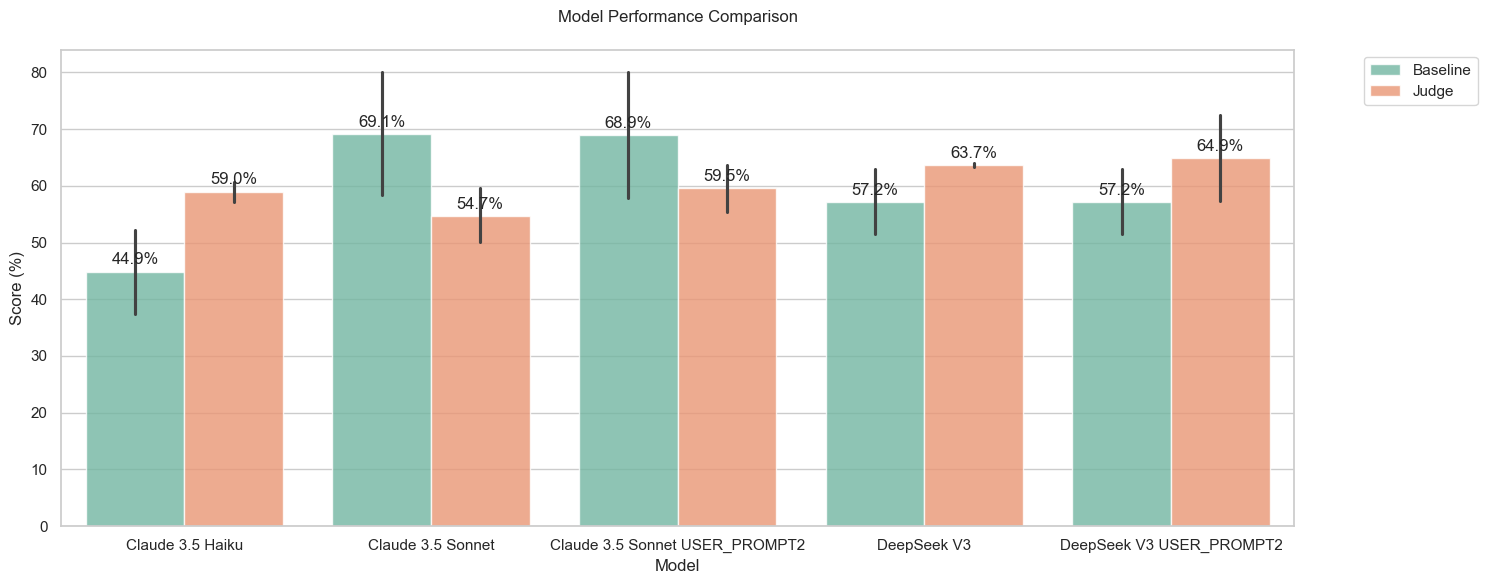

In [175]:
# Reshape data for grouped plotting
melted_df = pd.melt(
    metrics_df,
    id_vars=["Model"],
    value_vars=[
        "Baseline Accuracy",
        "Judge Accuracy",
        "Baseline F1 Score",
        "Judge F1 Score",
    ],
    var_name="Metric",
    value_name="Score",
)

# Split metric column into Type and Metric
melted_df[["Type", "Metric"]] = melted_df["Metric"].str.split(" ", n=1, expand=True)
melted_df["Score"] = melted_df["Score"] * 100

# Create grouped bar plot
plt.figure(figsize=(15, 6))
sns.barplot(data=melted_df, x="Model", y="Score", hue="Type", alpha=0.8, palette="Set2")

plt.title("Model Performance Comparison", pad=20)
plt.xlabel("Model")
plt.ylabel("Score (%)")

# Customize legend
plt.legend(title="", bbox_to_anchor=(1.05, 1), loc="upper left")

# Add percentage labels on bars
for i in plt.gca().containers:
    plt.gca().bar_label(i, fmt="%.1f%%", padding=3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

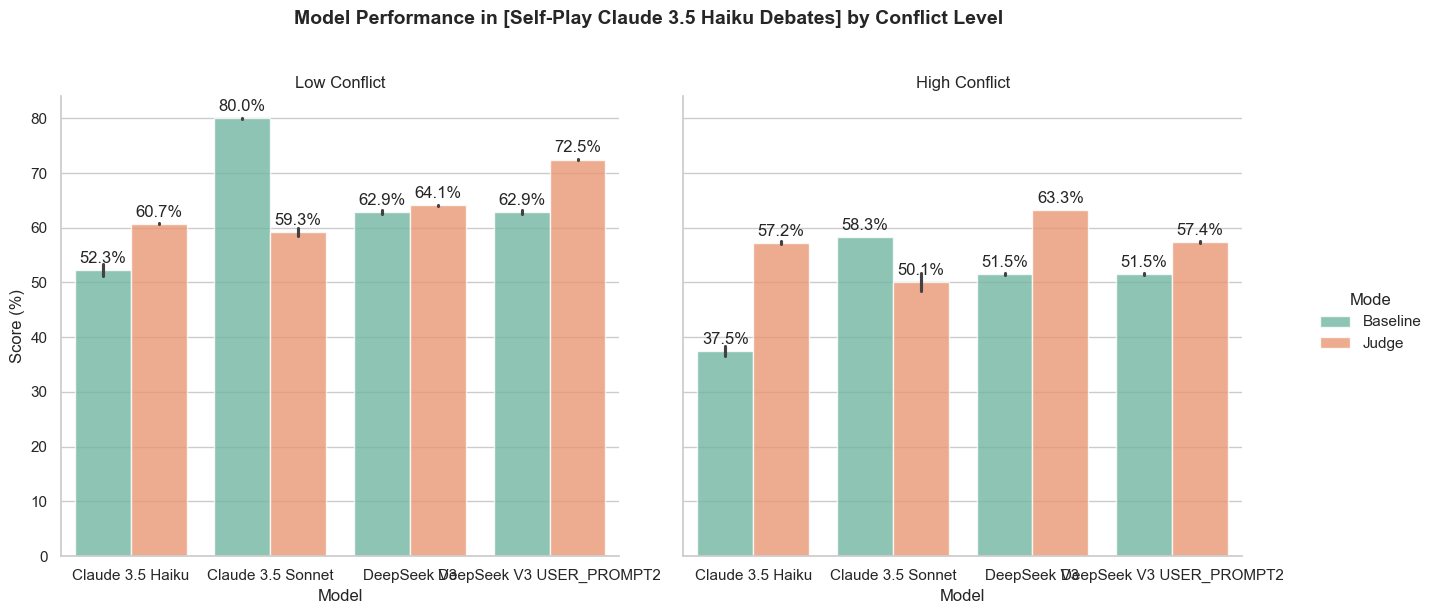

In [166]:
# Reshape data for grouped plotting
melted_df = pd.melt(
    metrics_df,
    id_vars=["Model", "Level"],
    value_vars=[
        "Baseline Accuracy",
        "Judge Accuracy",
        "Baseline F1 Score",
        "Judge F1 Score",
    ],
    var_name="Metric",
    value_name="Score",
)

# Split metric column and format data
melted_df[["Type", "Metric"]] = melted_df["Metric"].str.split(" ", n=1, expand=True)
melted_df["Score"] = melted_df["Score"] * 100
melted_df["level"] = melted_df["Level"].map(
    {"LowConflict": "Low Conflict", "HighConflict": "High Conflict"}
)

# Create faceted bar plot
g = sns.FacetGrid(melted_df, col="level", height=6, aspect=1)
g.map_dataframe(
    sns.barplot, x="Model", y="Score", hue="Type", alpha=0.8, palette="Set2"
)

# Customize plot
g.set_axis_labels("Model", "Score (%)")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Mode", bbox_to_anchor=(1.0, 0.5), loc="center left")

# Add percentage labels
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", padding=3)

plt.suptitle(
    "Model Performance in [Self-Play Claude 3.5 Haiku Debates] by Conflict Level",
    y=1.02,
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()


Claude 3.5 Haiku Quote Accuracy Difference:
           model        level  correct_acc_diff  incorrect_acc_diff  effect_size  p_value
Claude 3.5 Haiku HighConflict         -0.054468           -0.088032     0.033565 0.272519
Claude 3.5 Haiku  LowConflict         -0.119934           -0.086305    -0.033629 0.359726

Claude 3.5 Sonnet Quote Accuracy Difference:


C:\Users\Hp\AppData\Local\Temp\ipykernel_18240\776879824.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: stats.pointbiserialr(x["judge_correct"], x["quote_acc_diff"]))
C:\Users\Hp\AppData\Local\Temp\ipykernel_18240\776879824.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: stats.pointbiserialr(x["judge_correct"], x["quote_acc_diff"]))


            model        level  correct_acc_diff  incorrect_acc_diff  effect_size  p_value
Claude 3.5 Sonnet HighConflict         -0.069430           -0.067987    -0.001443 0.962070
Claude 3.5 Sonnet  LowConflict         -0.112803           -0.097701    -0.015102 0.680182

DeepSeek V3 Quote Accuracy Difference:
      model        level  correct_acc_diff  incorrect_acc_diff  effect_size  p_value
DeepSeek V3 HighConflict         -0.076771           -0.054849    -0.021922 0.485466
DeepSeek V3  LowConflict         -0.122305           -0.078931    -0.043374 0.245352

DeepSeek V3 USER_PROMPT2 Quote Accuracy Difference:


C:\Users\Hp\AppData\Local\Temp\ipykernel_18240\776879824.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: stats.pointbiserialr(x["judge_correct"], x["quote_acc_diff"]))
C:\Users\Hp\AppData\Local\Temp\ipykernel_18240\776879824.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: stats.pointbiserialr(x["judge_correct"], x["quote_acc_diff"]))


                   model        level  correct_acc_diff  incorrect_acc_diff  effect_size  p_value
DeepSeek V3 USER_PROMPT2 HighConflict         -0.064700           -0.074188     0.009488 0.756990
DeepSeek V3 USER_PROMPT2  LowConflict         -0.120042           -0.071752    -0.048290 0.228346


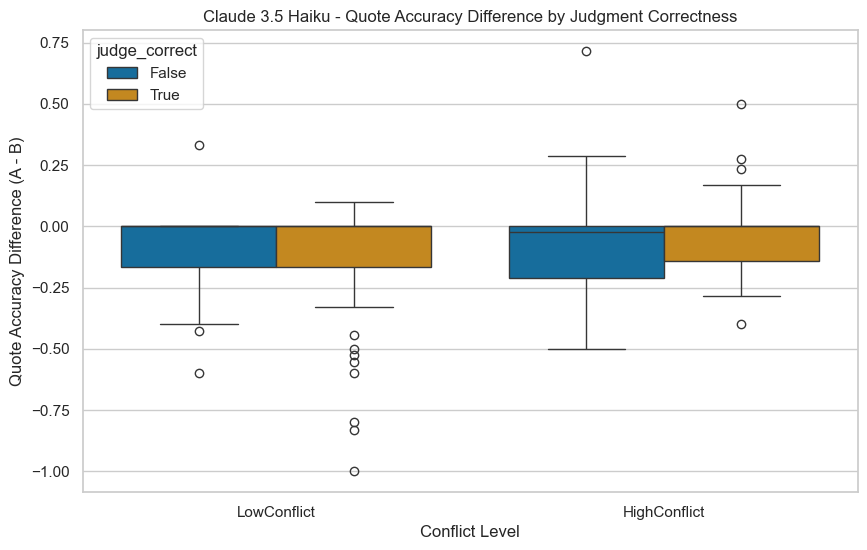

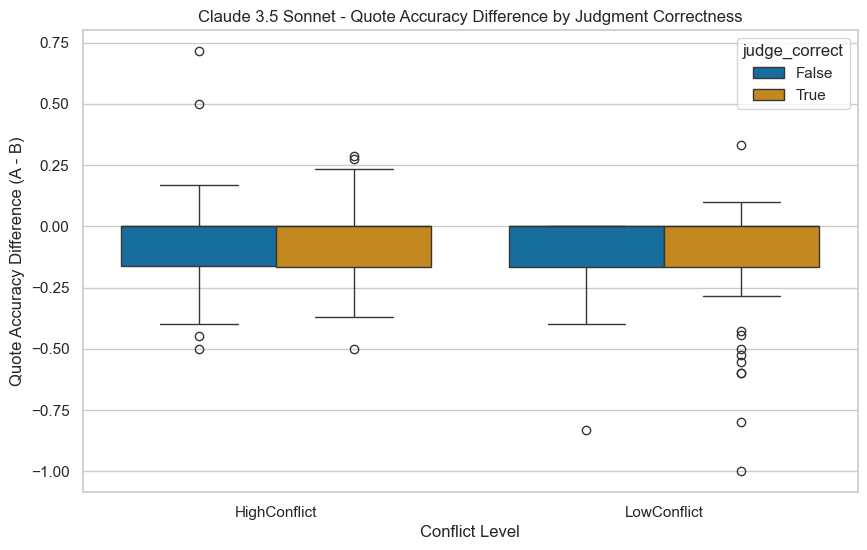

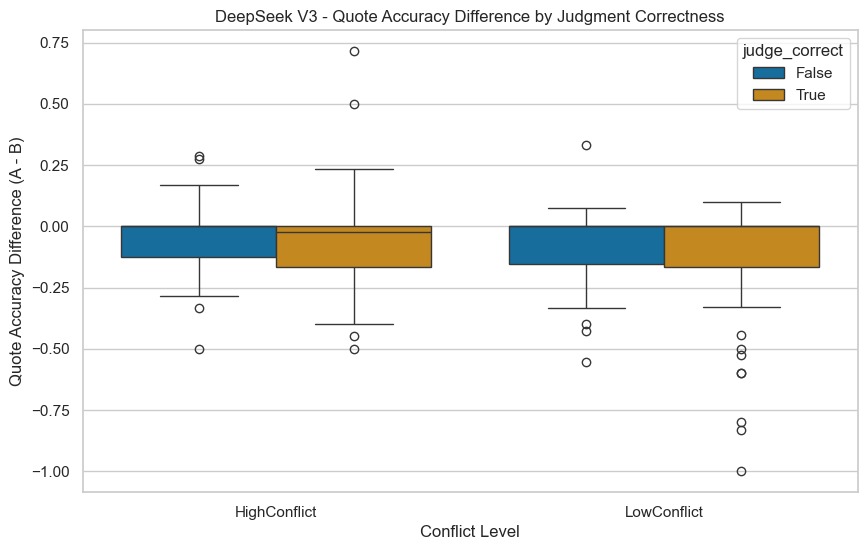

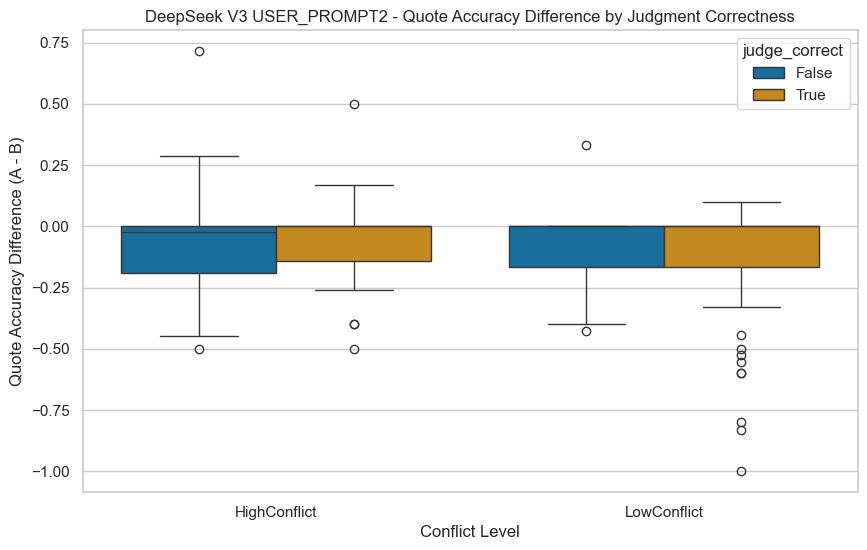

In [167]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


# Analyze the relationship between quote accuracy and correct judgments
def analyze_quote_patterns(model_name):
    results = []

    for level in ["HighConflict", "LowConflict"]:
        level_df = df[df["level"] == level]

        # Calculate mean quote accuracy difference for correct vs incorrect judgments
        correct_acc_diff = level_df[level_df["judge_correct"]]["quote_acc_diff"].mean()
        incorrect_acc_diff = level_df[~level_df["judge_correct"]][
            "quote_acc_diff"
        ].mean()

        # Perform t-test
        t_stat, p_val = stats.ttest_ind(
            level_df[level_df["judge_correct"]]["quote_acc_diff"],
            level_df[~level_df["judge_correct"]]["quote_acc_diff"],
        )

        results.append(
            {
                "model": model_name,
                "level": level,
                "correct_acc_diff": correct_acc_diff,
                "incorrect_acc_diff": incorrect_acc_diff,
                "effect_size": correct_acc_diff - incorrect_acc_diff,
                "p_value": p_val,
            }
        )

    return pd.DataFrame(results)


for model, df in dataframes.items():
    # Calculate quote accuracy difference
    print(f"\n{model} Quote Accuracy Difference:")

    # First, let's create a metric for quote accuracy disparity between debaters
    df["quote_acc_diff"] = df["a_quote_acc"] - df["b_quote_acc"]
    df["quote_num_diff"] = df["a_quote_num"] - df["b_quote_num"]

    # Create a binary column for correct judgments
    df["judge_correct"] = df["Judge Correct"] == 1
    # Calculate correlation between quote accuracy difference and judgment correctness
    correlation = (
        df.groupby("level")
        .apply(lambda x: stats.pointbiserialr(x["judge_correct"], x["quote_acc_diff"]))
        .reset_index()
    )

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="level", y="quote_acc_diff", hue="judge_correct")
    plt.title(f"{model} - Quote Accuracy Difference by Judgment Correctness")
    plt.xlabel("Conflict Level")
    plt.ylabel("Quote Accuracy Difference (A - B)")

    # Print statistical summary
    print(analyze_quote_patterns(model).to_string(index=False))

In [168]:
# Get the record where Haiku is correct but Sonnet is incorrect
dataframes_ = {
    model: df[df["correct_debater_pos"] != -1] for model, df in dataframes.items()
}

haiku_correct = dataframes_["Claude 3.5 Haiku"][
    dataframes_["Claude 3.5 Haiku"]["Judge Correct"] == 1
]["record_id"]
sonnet_correct = dataframes_["Claude 3.5 Sonnet"][
    dataframes_["Claude 3.5 Sonnet"]["Judge Correct"] == 1
]["record_id"]

record_only_haiku_correct = set(haiku_correct) - set(sonnet_correct)
len(record_only_haiku_correct)

39

In [169]:
# Get the label proportions for the scenarios where Haiku is correct but Sonnet is incorrect
only_haiku_correct_df = dataframes_["Claude 3.5 Haiku"][
    dataframes_["Claude 3.5 Haiku"]["record_id"].isin(record_only_haiku_correct)
]
print("Label Proportions for Debate Records where Haiku is Correct but Sonnet is Incorrect:")
only_haiku_correct_df["label"].value_counts()

Label Proportions for Debate Records where Haiku is Correct but Sonnet is Incorrect:


label
disproved    28
proved       10
unknown       1
Name: count, dtype: int64

In [147]:
# Filter for high-conflict scenarios with known correct answers
high_conflict_subset = df[
    (df['level'] == 'HighConflict') &
    (df['correct_debater_pos'] != -1)
]

# Create metrics for quote quantity analysis
high_conflict_subset['chosen_quote_num'] = high_conflict_subset.apply(
    lambda row: row['a_quote_num'] if row['chosen_debater'] == 1
    else row['b_quote_num'], axis=1
)
high_conflict_subset['opposing_quote_num'] = high_conflict_subset.apply(
    lambda row: row['b_quote_num'] if row['chosen_debater'] == 1
    else row['a_quote_num'], axis=1
)

# Compare quote quantity patterns between correct and incorrect judgments
analysis = stats.ttest_ind(
    high_conflict_subset[high_conflict_subset['judge_correct']]['chosen_quote_num'],
    high_conflict_subset[~high_conflict_subset['judge_correct']]['chosen_quote_num']
)
analysis

C:\Users\Hp\AppData\Local\Temp\ipykernel_18240\1148564241.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conflict_subset['chosen_quote_num'] = high_conflict_subset.apply(
C:\Users\Hp\AppData\Local\Temp\ipykernel_18240\1148564241.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conflict_subset['opposing_quote_num'] = high_conflict_subset.apply(


TtestResult(statistic=np.float64(1.0585343617246383), pvalue=np.float64(0.2919739814294529), df=np.float64(118.0))

In [132]:
import json

def get_scenario_id(record_id: str, df: pd.DataFrame) -> str:
    return df[df["record_id"] == record_id]["scenario_id"].values[0]

debate_name = "claude-3.5-haiku vs claude-3.5-haiku"

record2scenario = {record_id: get_scenario_id(record_id, df) for record_id in record_only_haiku_correct}
scenario2record = {}
for record_id, scenario_id in record2scenario.items():
    if scenario_id not in scenario2record:
        scenario2record[scenario_id] = []
    scenario2record[scenario_id].append(record_id)


base_path = Path("../results")

i = 0
for scenario_id in scenario2record.keys():

    # Load the scenario text
    with open(base_path / "scenarios" / f"{scenario_id}.json", "r") as file:
        scenario_text = json.loads(file.read())

    print(f"# Scenario ID: {scenario_id}")
    print(f"Example {i+1} of {len(scenario2record)}")
    print(json.dumps(scenario_text, indent=2))

    for record_id in scenario2record[scenario_id]:
        print("\n## Record ID:", record_id)

        # Display the judge's answer
        print("\nJudge's Answer:\n")
        for model in ["claude-3.5-haiku", "claude-3-5-sonnet-20241022"]:
            with open(base_path / "judgements" / debate_name / model / f"{scenario_id}_{record_id}.json", "r") as file:
                answer = json.load(file)
            print("-" * 40)
            print(f"### {model}:")
            print(answer["judgement"])
            print()

    print("="*80 + "\n")

# Scenario ID: d859cf431a257c1791071e4715c894d1
Example 1 of 36
{
  "situation": "A few players are playing a boardgame. The current state of the game is as follows. The gorilla has 7 friends, and invented a time machine. The gorilla has a 11 x 16 inches notebook, and has a card that is white in color. The shark captures the king of the dinosaur. And the rules of the game are as follows. Rule1: The bulldog invests in the company owned by the butterfly whenever at least one animal captures the king of the dinosaur. Rule2: Regarding the gorilla, if it has a notebook that fits in a 6.2 x 18.4 inches box, then we can conclude that it does not destroy the wall built by the cobra. Rule3: Regarding the gorilla, if it has a card whose color appears in the flag of France, then we can conclude that it destroys the wall constructed by the cobra. Rule4: This is a basic rule: if the bee stops the victory of the bulldog, then the conclusion that \"the bulldog will not invest in the company owned by 

In [136]:
len(record2scenario), len(scenario2record)

(39, 36)